# Accelerating learning in Evolutionary Robotics
(Dario Izzo)

## 1 - Importing stuff


In [147]:
from pyaudi import gdual, sin, cos, tan
from random import random
from matplotlib import pyplot as plt
%matplotlib inline

## 2 - Controller representation and "simulator"
The controller is tipycally represented by a neural net, but for the purpose of explaining this new learning concept we will just use polinomials. Later, changing the controllers into a NN with weights as params will not change the essence of what is done here.

In [148]:
# Definition of the controller in terms of the weights parameters
def u(state, weights):
    x,v = state
    a,b,c,e,f,g = weights
    return a + b*x + c*v + e*x*v + f*x**2 + g*v**2

In [149]:
# Definition of the equation of motion (our physics simulator propagating the system to its next state)
def eom(state, weights):
    x,v = state
    dx = v
    dv = u(state, weights)
    return (dx, dv)

## 3 - The Euler Propagation
In ER Euler propagators are commonly used. The essence of what is done here would not change the if we code a Newton Raphson or a better method.

In [160]:
weights = [gdual(0.2*(random()-0.5), _, 1) for _ in "abcefg"]
x = [gdual(2*(random()-0.5))]
v = [gdual(2*(random()-0.5))]
dt = 0.1
# We propagate for 10 seconds (cannot oincrease this much as the control is polynomial thus x**2 and v**2 would make u1 biiiig)
for i in range(100):
    dx, dv = eom([x[-1],v[-1]], weights)
    x.append(x[-1] + dt * dx)
    v.append(v[-1] + dt * dv)

NOTE: the resulting final point is a gdual, it contains information on how the final state reached by our "robot" will change if we change the control weights!!

In [151]:
x[0], x[-1]

(0.374029,
 -13.3274*db+6.28395*dg-19.2619*dc+83.0189*da+33.5559*df+10.3767*de-3.61131)

In [152]:
v[0],v[-1]

(-0.0195213,
 -10.5003*db+4.03876*dg-10.2593*dc+39.9357*da+26.3506*df+8.31487*de-1.21923)

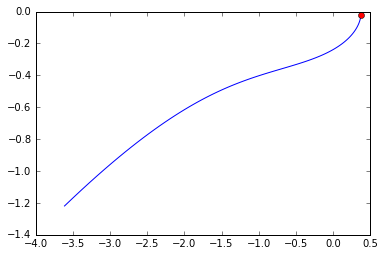

In [156]:
plt.plot([it.constant_cf for it in x],[it.constant_cf for it in v])
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.show()

In [159]:
xf, vf = x[-1], v[-1]

In [161]:
xf

-13.3274*db+6.28395*dg-19.2619*dc+83.0189*da+33.5559*df+10.3767*de-3.61131

In [162]:
vf

-10.5003*db+4.03876*dg-10.2593*dc+39.9357*da+26.3506*df+8.31487*de-1.21923

We have represented all the robot behavior (x, v) as a polynomial function of the weight. So we now know what happens to the behaviour if we change the weights!!